# Tweet Virality Analysis
## Understanding patterns in viral vs non-viral tweets

In [27]:
# Install emoji if not available
import subprocess
import sys
import emoji

# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import re
import string
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load the dataset
df = pd.read_csv('/scratch/ihmehta/SemanticWebMining/energy/cleaned_dataset.csv')
df = df[df['post_type'].notna()]

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
display(df.head())
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (260959, 15)

Column names: ['item_id', 'user_id', 'parent_item_id', 'parent_user_id', 'post_type', 'content', 'lang', 'created_at', 'retweet_count', 'reply_count', 'like_count', 'quote_count', 'bookmark_count', 'impression_count', 'favorite_count']

First few rows:


,item_id,user_id,parent_item_id,parent_user_id,post_type,content,lang,created_at,retweet_count,reply_count,like_count,quote_count,bookmark_count,impression_count,favorite_count
0,tw1890189052546330798,tw1078316268,tw1890187508950155293,tw14216661,reply,@nationalpost Do you know how Canada could be ...,en,2025-02-13T23:59:22+00:00,0.0,0.0,2.0,0.0,0.0,50.0,2.0
1,tw1890188670977863943,tw1580325352509169664,tw1890098704700387792,tw1540460409190174720,reply,@DelusionPosting No natural gas in Canada? Cuz...,en,2025-02-13T23:57:51+00:00,0.0,0.0,0.0,0.0,0.0,24.0,0.0
2,tw1890188637817786858,tw1767341977698172928,tw1889850407041769822,tw1403784319122907136,reply,@BehizyTweets Lots of companies didn’t get gra...,en,2025-02-13T23:57:43+00:00,0.0,0.0,1.0,0.0,0.0,6.0,1.0
3,tw1890188525762642280,tw1107412116,tw1890160269802025270,tw842844134314397696,retweet,Most Canadians know the TRUTH: liquefied natur...,en,2025-02-13T23:57:17+00:00,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tw1890188220870324406,tw1446674734113042435,NaN,NaN,post,President Trump just announced that India has ...,en,2025-02-13T23:56:04+00:00,0.0,0.0,2.0,0.0,0.0,31.0,2.0



Data types:
item_id              object
user_id              object
parent_item_id       object
parent_user_id       object
post_type            object
content              object
lang                 object
created_at           object
retweet_count       float64
reply_count         float64
like_count          float64
quote_count         float64
bookmark_count      float64
impression_count    float64
favorite_count      float64
dtype: object

Missing values:
item_id                 0
user_id                 0
parent_item_id      51555
parent_user_id      51555
post_type               0
content                 0
lang                    0
created_at              0
retweet_count           0
reply_count             0
like_count              0
quote_count             0
bookmark_count          0
impression_count        0
favorite_count          0
dtype: int64


In [28]:
(df.impression_count==0).sum()

172648

In [29]:
# ============================================================================
# HYBRID APPROACH: Handle tweets with and without impressions separately
# ============================================================================

# FIRST: Filter out pure retweets - they inherit parent's stats, not their own
# Only analyze original posts and quotes (which have original content)
print(f"Post type distribution BEFORE filtering:")
print(df['post_type'].value_counts())

# Keep only posts and quotes (retweets don't have their own engagement)
df_analysis = df[df['post_type'].isin(['post', 'quote',"reply"])].copy()
print(f"\nPost type distribution AFTER filtering (removing retweets):")
print(df_analysis['post_type'].value_counts())
print(f"Removed {len(df) - len(df_analysis):,} retweets")

# Now split by impression availability
has_impressions = df_analysis['impression_count'] > 0
df_with_imp = df_analysis[has_impressions].copy()
df_no_imp = df_analysis[~has_impressions].copy()

print(f"\nTweets WITH impressions: {len(df_with_imp):,}")
print(f"Tweets WITHOUT impressions: {len(df_no_imp):,}")

# ============================================================================
# GROUP 1: Tweets WITH impressions → Use Engagement Rate (normalized)
# ============================================================================
w_like, w_rt, w_reply, w_quote = 1, 4, 3, 4

df_with_imp['engagement_rate'] = (
    (df_with_imp['like_count'] * w_like) + 
    (df_with_imp['retweet_count'] * w_rt) + 
    (df_with_imp['reply_count'] * w_reply) + 
    (df_with_imp['quote_count'] * w_quote)
) / df_with_imp['impression_count']

df_with_imp['log_absolute_score'] = (
    np.log1p(df_with_imp['like_count']) * w_like + 
    np.log1p(df_with_imp['retweet_count']) * w_rt + 
    np.log1p(df_with_imp['reply_count']) * w_reply + 
    np.log1p(df_with_imp['quote_count']) * w_quote + 
    np.log1p(df_with_imp['bookmark_count']) * 0.5
)

df_with_imp['er_percentile'] = df_with_imp['engagement_rate'].rank(pct=True)
df_with_imp['abs_percentile'] = df_with_imp['log_absolute_score'].rank(pct=True)
df_with_imp['final_viral_score'] = (
    df_with_imp['er_percentile'] * 0.7 + df_with_imp['abs_percentile'] * 0.3
)

# ============================================================================
# GROUP 2: Tweets WITHOUT impressions → Use ONLY absolute engagement
# ============================================================================
if len(df_no_imp) > 0:
    df_no_imp['log_absolute_score'] = (
        np.log1p(df_no_imp['like_count']) * w_like + 
        np.log1p(df_no_imp['retweet_count']) * w_rt + 
        np.log1p(df_no_imp['reply_count']) * w_reply + 
        np.log1p(df_no_imp['quote_count']) * w_quote + 
        np.log1p(df_no_imp['bookmark_count']) * 0.5
    )
    
    df_no_imp['total_engagement'] = (
        df_no_imp['like_count'] + df_no_imp['retweet_count'] + 
        df_no_imp['reply_count'] + df_no_imp['quote_count']
    )
    
    # Minimum thresholds
    MIN_ENGAGEMENT_FOR_VIRAL = 10
    MIN_LIKES_FOR_VIRAL = 5
    
    df_no_imp['abs_percentile'] = df_no_imp['log_absolute_score'].rank(pct=True)
    df_no_imp['final_viral_score'] = df_no_imp['abs_percentile']
    df_no_imp['engagement_rate'] = np.nan
    df_no_imp['er_percentile'] = np.nan

# ============================================================================
# LABEL VIRAL STATUS
# ============================================================================
def assign_viral_status_with_imp(group_df):
    top_5 = group_df['final_viral_score'].quantile(0.95)
    bottom_50 = group_df['final_viral_score'].quantile(0.50)
    
    group_df['viral_status'] = 'NEUTRAL'
    group_df.loc[group_df['final_viral_score'] >= top_5, 'viral_status'] = 'VIRAL'
    group_df.loc[group_df['final_viral_score'] <= bottom_50, 'viral_status'] = 'NON_VIRAL'
    
    print(f"\nWITH Impressions Distribution:")
    print(group_df['viral_status'].value_counts())
    return group_df

def assign_viral_status_no_imp(group_df):
    if len(group_df) == 0:
        return group_df
        
    top_5 = group_df['final_viral_score'].quantile(0.95)
    bottom_50 = group_df['final_viral_score'].quantile(0.50)
    
    group_df['viral_status'] = 'NEUTRAL'
    
    viral_mask = (
        (group_df['final_viral_score'] >= top_5) & 
        (
            (group_df['total_engagement'] >= MIN_ENGAGEMENT_FOR_VIRAL) |
            (group_df['like_count'] >= MIN_LIKES_FOR_VIRAL)
        )
    )
    group_df.loc[viral_mask, 'viral_status'] = 'VIRAL'
    
    non_viral_mask = (
        (group_df['final_viral_score'] <= bottom_50) |
        (group_df['total_engagement'] == 0)
    )
    group_df.loc[non_viral_mask, 'viral_status'] = 'NON_VIRAL'
    
    print(f"\nWITHOUT Impressions Distribution:")
    print(group_df['viral_status'].value_counts())
    return group_df

df_with_imp = assign_viral_status_with_imp(df_with_imp)
if len(df_no_imp) > 0:
    df_no_imp = assign_viral_status_no_imp(df_no_imp)

# ============================================================================
# MERGE BACK
# ============================================================================
df_with_imp['scoring_method'] = 'hybrid_ER'
if len(df_no_imp) > 0:
    df_no_imp['scoring_method'] = 'absolute_only'
    df = pd.concat([df_with_imp, df_no_imp], ignore_index=True)
else:
    df = df_with_imp.copy()

print(f"\n" + "="*60)
print("COMBINED DATASET SUMMARY (Original posts + Quotes only)")
print("="*60)
print(f"Total tweets: {len(df):,}")
print(f"\nViral Status (Overall):")
print(df['viral_status'].value_counts())
print(f"\nScoring Method Distribution:")
print(df['scoring_method'].value_counts())

# ============================================================================
# SANITY CHECKS
# ============================================================================
print(f"\n" + "="*60)
print("SANITY CHECKS")
print("="*60)

viral_df = df[df['viral_status']=='VIRAL']
non_viral_df = df[df['viral_status']=='NON_VIRAL']

print(f"Viral median likes: {viral_df['like_count'].median():.0f}")
print(f"Non-viral median likes: {non_viral_df['like_count'].median():.0f}")
print(f"✓ Viral > Non-viral likes: {viral_df['like_count'].median() > non_viral_df['like_count'].median()}")

print(f"\nViral median retweets: {viral_df['retweet_count'].median():.0f}")
print(f"Non-viral median retweets: {non_viral_df['retweet_count'].median():.0f}")
print(f"✓ Viral > Non-viral retweets: {viral_df['retweet_count'].median() > non_viral_df['retweet_count'].median()}")

print(f"\nViral tweets with 0 engagement: {(viral_df['log_absolute_score'] == 0).sum()}")
print(f"✓ No viral tweet has 0 engagement: {(viral_df['log_absolute_score'] == 0).sum() == 0}")

Post type distribution BEFORE filtering:
post_type
retweet    157093
post        51555
reply       47259
quote        5052
Name: count, dtype: int64

Post type distribution AFTER filtering (removing retweets):
post_type
post     51555
reply    47259
quote     5052
Name: count, dtype: int64
Removed 157,093 retweets

Tweets WITH impressions: 88,123
Tweets WITHOUT impressions: 15,743

WITH Impressions Distribution:
viral_status
NON_VIRAL    44062
NEUTRAL      39653
VIRAL         4408
Name: count, dtype: int64

WITHOUT Impressions Distribution:
viral_status
NON_VIRAL    15543
VIRAL          141
NEUTRAL         59
Name: count, dtype: int64

COMBINED DATASET SUMMARY (Original posts + Quotes only)
Total tweets: 103,866

Viral Status (Overall):
viral_status
NON_VIRAL    59605
NEUTRAL      39712
VIRAL         4549
Name: count, dtype: int64

Scoring Method Distribution:
scoring_method
hybrid_ER        88123
absolute_only    15743
Name: count, dtype: int64

SANITY CHECKS
Viral median likes: 4
Non

In [30]:
# Quick diagnostic: What do viral tweets from the NO_IMP group look like?
viral_no_imp = df[(df['viral_status']=='VIRAL') & (df['scoring_method']=='absolute_only')]
viral_with_imp = df[(df['viral_status']=='VIRAL') & (df['scoring_method']=='hybrid_ER')]

print("VIRAL tweets from NO_IMP group (sample stats):")
print(viral_no_imp[['like_count', 'retweet_count', 'reply_count', 'quote_count']].describe())

print("\nVIRAL tweets from WITH_IMP group (sample stats):")
print(viral_with_imp[['like_count', 'retweet_count', 'reply_count', 'quote_count']].describe())

print("\n" + "="*60)
print("Sample viral tweet content from NO_IMP group:")
print("="*60)
for idx, row in viral_no_imp.head(3).iterrows():
    print(f"\nLikes: {row['like_count']:.0f} | RTs: {row['retweet_count']:.0f}")
    print(f"Content: {str(row['content'])[:150]}...")

VIRAL tweets from NO_IMP group (sample stats):
          like_count  retweet_count   reply_count    quote_count
count     141.000000     141.000000    141.000000     141.000000
mean     4958.297872    1113.000000    910.234043    2504.326241
std     16005.702585    2506.292222   8164.923748   26952.609098
min         1.000000       0.000000      0.000000       0.000000
25%       101.000000      31.000000      2.000000       1.000000
50%       455.000000     117.000000     13.000000      10.000000
75%      2610.000000     631.000000     92.000000      56.000000
max    163521.000000   14461.000000  96625.000000  319950.000000

VIRAL tweets from WITH_IMP group (sample stats):
          like_count  retweet_count   reply_count    quote_count
count    4408.000000    4408.000000   4408.000000    4408.000000
mean     1759.378857     370.463929    119.025408      87.579174
std      9662.809113    1846.478183    665.677884    2937.453325
min         0.000000       0.000000      0.000000       0.

## Step 1: Create Engagement Score and Viral Labels

In [31]:
# Extract tweet features for pattern analysis
def extract_features(text):
    if pd.isna(text):
        return {
            'length': 0,
            'word_count': 0,
            'has_question': 0,
            'has_exclamation': 0,
            'has_url': 0,
            'has_hashtag': 0,
            'has_mention': 0,
            'emoji_count': 0,
            'uppercase_ratio': 0,
            'avg_word_length': 0
        }
    
    text = str(text)
    
    # Count features
    emojis = [c for c in text if c in emoji.EMOJI_DATA]
    
    features = {
        'length': len(text),
        'word_count': len(text.split()),
        'has_question': 1 if '?' in text else 0,
        'has_exclamation': 1 if '!' in text else 0,
        'has_url': 1 if 'http' in text or 't.co' in text else 0,
        'has_hashtag': 1 if '#' in text else 0,
        'has_mention': 1 if '@' in text else 0,
        'emoji_count': len(emojis),
        'uppercase_ratio': sum(1 for c in text if c.isupper()) / max(len(text), 1),
        'avg_word_length': np.mean([len(w) for w in text.split()]) if text.split() else 0
    }
    return features

# Extract all features
features_df = df['content'].apply(extract_features).apply(pd.Series)
df = pd.concat([df, features_df], axis=1)

# Extract time of day features
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Add post type feature
df['is_retweet'] = (df['post_type'] == 'retweet').astype(int)
df['is_quote'] = (df['post_type'] == 'quote').astype(int)
df['is_original'] = (df['post_type'] == 'post').astype(int)

print("Feature extraction complete!")
print(f"\nFeatures created: {features_df.columns.tolist()}")
print(f"\nFeature statistics by viral status:")
print(df.groupby('viral_status')[features_df.columns.tolist()].mean())

Feature extraction complete!

Features created: ['length', 'word_count', 'has_question', 'has_exclamation', 'has_url', 'has_hashtag', 'has_mention', 'emoji_count', 'uppercase_ratio', 'avg_word_length']

Feature statistics by viral status:
                  length  word_count  has_question  has_exclamation   has_url  \
viral_status                                                                    
NEUTRAL       193.087455   31.581210      0.157081         0.108481  0.285732   
NON_VIRAL     183.990739   24.744585      0.083735         0.375187  0.528261   
VIRAL         199.212794   31.343372      0.159376         0.158936  0.355683   

              has_hashtag  has_mention  emoji_count  uppercase_ratio  \
viral_status                                                           
NEUTRAL          0.069098     0.541650     0.380615         0.071560   
NON_VIRAL        0.173509     0.753444     1.345743         0.102307   
VIRAL            0.112332     0.491537     0.600572         0.08585

## Step 2: Analyze Tweet Patterns (Length, Media, Emojis, Time, etc.)

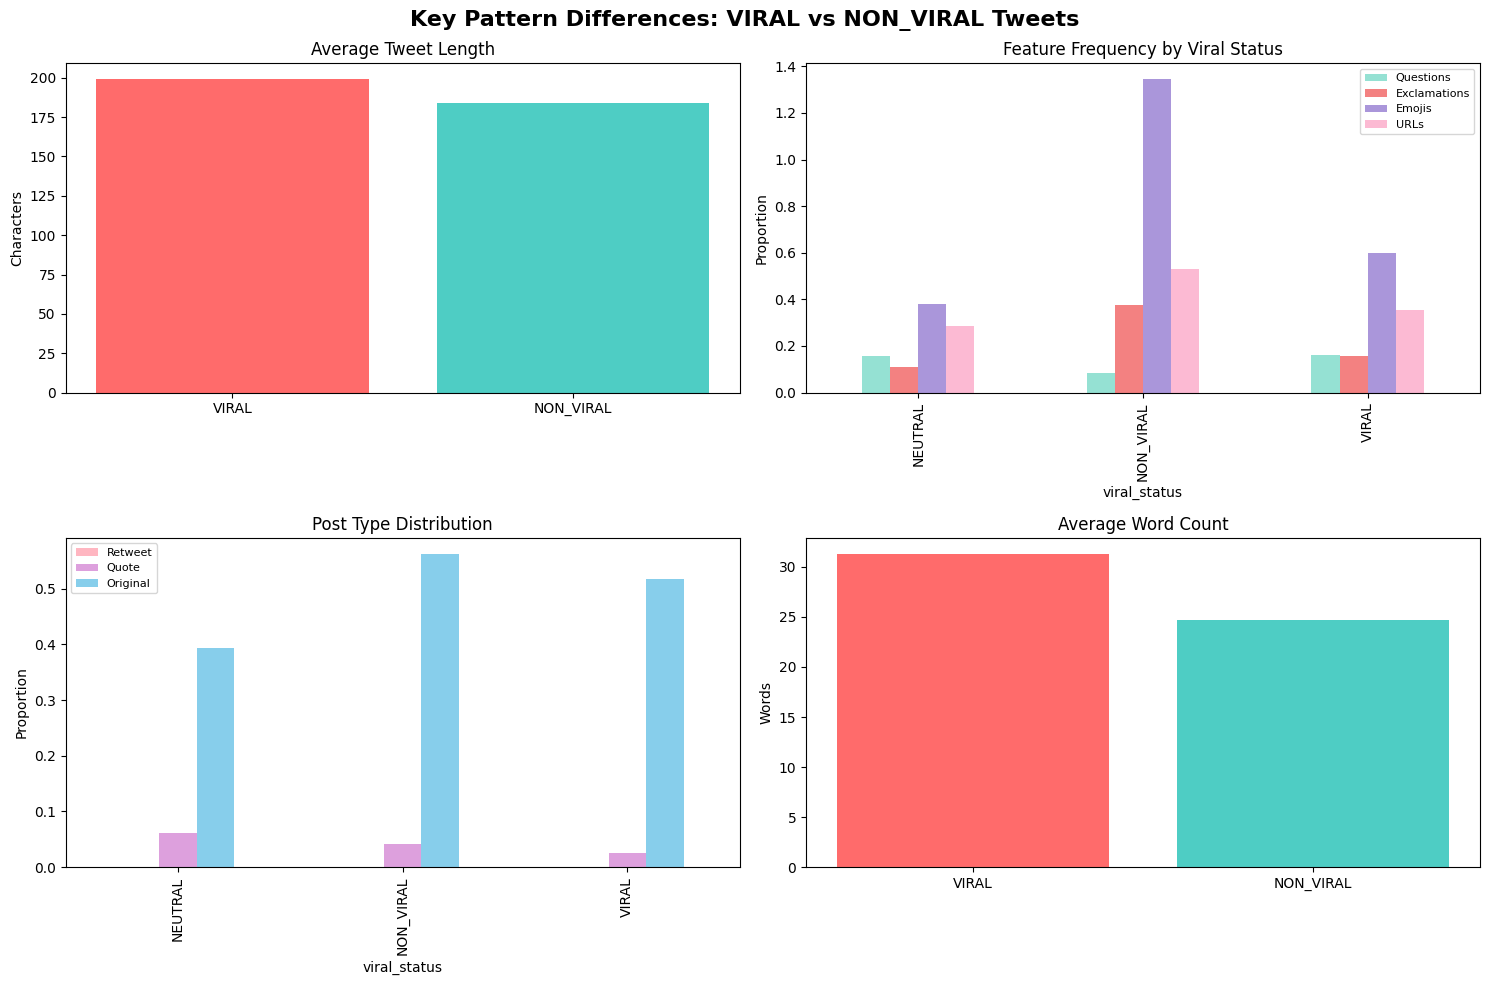


DETAILED PATTERN ANALYSIS

LENGTH:
  VIRAL: 199.213 | NON_VIRAL: 183.991 | Difference: +8.3%

WORD_COUNT:
  VIRAL: 31.343 | NON_VIRAL: 24.745 | Difference: +26.7%

HAS_QUESTION:
  VIRAL: 0.159 | NON_VIRAL: 0.084 | Difference: +90.3%

HAS_EXCLAMATION:
  VIRAL: 0.159 | NON_VIRAL: 0.375 | Difference: -57.6%

HAS_URL:
  VIRAL: 0.356 | NON_VIRAL: 0.528 | Difference: -32.7%

HAS_HASHTAG:
  VIRAL: 0.112 | NON_VIRAL: 0.174 | Difference: -35.3%

HAS_MENTION:
  VIRAL: 0.492 | NON_VIRAL: 0.753 | Difference: -34.8%

EMOJI_COUNT:
  VIRAL: 0.601 | NON_VIRAL: 1.346 | Difference: -55.4%

UPPERCASE_RATIO:
  VIRAL: 0.086 | NON_VIRAL: 0.102 | Difference: -16.1%

AVG_WORD_LENGTH:
  VIRAL: 5.772 | NON_VIRAL: 6.719 | Difference: -14.1%

AVG_WORD_LENGTH:
  VIRAL: 5.772 | NON_VIRAL: 6.719 | Difference: -14.1%


In [32]:
# Comprehensive pattern comparison between VIRAL and NON_VIRAL
pattern_comparison = df.groupby('viral_status')[features_df.columns.tolist()].agg(['mean', 'std'])

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Key Pattern Differences: VIRAL vs NON_VIRAL Tweets', fontsize=16, fontweight='bold')

# Plot 1: Tweet Length
viral_len = df[df['viral_status'] == 'VIRAL']['length'].mean()
non_viral_len = df[df['viral_status'] == 'NON_VIRAL']['length'].mean()
axes[0, 0].bar(['VIRAL', 'NON_VIRAL'], [viral_len, non_viral_len], color=['#FF6B6B', '#4ECDC4'])
axes[0, 0].set_title('Average Tweet Length')
axes[0, 0].set_ylabel('Characters')

# Plot 2: Engagement Metrics
engagement_by_status = df.groupby('viral_status')[['has_question', 'has_exclamation', 'emoji_count', 'has_url']].mean()
engagement_by_status.plot(kind='bar', ax=axes[0, 1], color=['#95E1D3', '#F38181', '#AA96DA', '#FCBAD3'])
axes[0, 1].set_title('Feature Frequency by Viral Status')
axes[0, 1].set_ylabel('Proportion')
axes[0, 1].legend(['Questions', 'Exclamations', 'Emojis', 'URLs'], fontsize=8)

# Plot 3: Post Type Distribution
post_type_dist = df.groupby('viral_status')[['is_retweet', 'is_quote', 'is_original']].mean()
post_type_dist.plot(kind='bar', ax=axes[1, 0], color=['#FFB6C1', '#DDA0DD', '#87CEEB'])
axes[1, 0].set_title('Post Type Distribution')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].legend(['Retweet', 'Quote', 'Original'], fontsize=8)

# Plot 4: Word Count
viral_words = df[df['viral_status'] == 'VIRAL']['word_count'].mean()
non_viral_words = df[df['viral_status'] == 'NON_VIRAL']['word_count'].mean()
axes[1, 1].bar(['VIRAL', 'NON_VIRAL'], [viral_words, non_viral_words], color=['#FF6B6B', '#4ECDC4'])
axes[1, 1].set_title('Average Word Count')
axes[1, 1].set_ylabel('Words')

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\n" + "="*80)
print("DETAILED PATTERN ANALYSIS")
print("="*80)

for feature in features_df.columns:
    viral_mean = df[df['viral_status'] == 'VIRAL'][feature].mean()
    non_viral_mean = df[df['viral_status'] == 'NON_VIRAL'][feature].mean()
    diff_pct = ((viral_mean - non_viral_mean) / non_viral_mean * 100) if non_viral_mean != 0 else 0
    print(f"\n{feature.upper()}:")
    print(f"  VIRAL: {viral_mean:.3f} | NON_VIRAL: {non_viral_mean:.3f} | Difference: {diff_pct:+.1f}%")

In [33]:
# Text preprocessing function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'http\S+|t\.co\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (keep the text)
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove special characters
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Preprocess texts
df['processed_content'] = df['content'].apply(preprocess_text)

# Get stop words
stop_words = set(stopwords.words('english'))

# Function to get words from text
def get_words(text):
    words = text.split()
    return [w for w in words if w and len(w) > 2 and w not in stop_words]

# Analyze VIRAL tweets
viral_tweets = df[df['viral_status'] == 'VIRAL']['processed_content'].str.cat(sep=' ')
viral_words = get_words(viral_tweets)
viral_word_freq = Counter(viral_words)

# Analyze NON_VIRAL tweets
non_viral_tweets = df[df['viral_status'] == 'NON_VIRAL']['processed_content'].str.cat(sep=' ')
non_viral_words = get_words(non_viral_tweets)
non_viral_word_freq = Counter(non_viral_words)

print("\nTOP 20 WORDS IN VIRAL TWEETS:")
print("="*60)
for word, count in viral_word_freq.most_common(20):
    print(f"{word}: {count}")

print("\n\nTOP 20 WORDS IN NON_VIRAL TWEETS:")
print("="*60)
for word, count in non_viral_word_freq.most_common(20):
    print(f"{word}: {count}")

# Analyze bigrams (2-word phrases)
print("\n" + "="*80)
print("BIGRAM ANALYSIS")
print("="*80)

def get_bigrams(text):
    words = text.split()
    words = [w for w in words if w and len(w) > 2 and w not in stop_words]
    return list(ngrams(words, 2))

viral_bigrams = []
for text in df[df['viral_status'] == 'VIRAL']['processed_content']:
    viral_bigrams.extend(get_bigrams(text))
viral_bigram_freq = Counter(viral_bigrams)

non_viral_bigrams = []
for text in df[df['viral_status'] == 'NON_VIRAL']['processed_content']:
    non_viral_bigrams.extend(get_bigrams(text))
non_viral_bigram_freq = Counter(non_viral_bigrams)

print("\nTOP 20 BIGRAMS IN VIRAL TWEETS:")
print("="*60)
for bigram, count in viral_bigram_freq.most_common(20):
    print(f"{' '.join(bigram)}: {count}")

print("\n\nTOP 20 BIGRAMS IN NON_VIRAL TWEETS:")
print("="*60)
for bigram, count in non_viral_bigram_freq.most_common(20):
    print(f"{' '.join(bigram)}: {count}")


TOP 20 WORDS IN VIRAL TWEETS:
shell: 1126
gas: 891
like: 400
natural: 383
oil: 345
russia: 304
amp: 300
one: 282
trump: 281
energy: 268
dont: 266
get: 250
lng: 244
people: 227
europe: 223
ukraine: 216
good: 206
russian: 204
new: 195
time: 182


TOP 20 WORDS IN NON_VIRAL TWEETS:
shell: 25161
users: 12221
gas: 11400
eligible: 7093
claim: 6629
airdrop: 6617
natural: 5854
pump: 5467
crypto: 5022
news: 4686
lng: 4673
live: 4633
token: 4434
oil: 4334
season: 4315
invited: 4161
presale: 3049
like: 2979
post: 2977
russia: 2931

BIGRAM ANALYSIS

TOP 20 BIGRAMS IN VIRAL TWEETS:
natural gas: 356
russian gas: 70
oil gas: 69
shell companies: 57
turbo 2013: 55
oil natural: 54
good morning: 37
russian energy: 37
shell game: 36
please please: 36
gas prices: 35
gas oil: 30
united states: 29
garden snail: 29
come shell: 26
nut shell: 25
good luck: 25
president trump: 24
becoming fastest: 24
indianapolis 500: 24


TOP 20 BIGRAMS IN NON_VIRAL TWEETS:
eligible users: 6975
airdrop eligible: 6461
users clai

## Step 3: Word Frequency and Bigram Analysis

In [34]:
# Topic Modeling using LDA
print("\n" + "="*80)
print("TOPIC MODELING - LATENT DIRICHLET ALLOCATION")
print("="*80)

# Prepare documents for LDA
viral_texts = df[df['viral_status'] == 'VIRAL']['processed_content'].tolist()

# Create document-term matrix
vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(viral_texts)

# Fit LDA model with 10 topics
lda_model = LatentDirichletAllocation(n_components=10, random_state=42, max_iter=20, verbose=0)
lda_model.fit(doc_term_matrix)

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Display topics
print("\nTOP 10 THEMES IN VIRAL TWEETS:")
print("="*80)

topics_list = []
for topic_id, topic in enumerate(lda_model.components_):
    top_indices = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    top_weights = [topic[i] for i in top_indices]
    
    topics_list.append({
        'topic_id': topic_id,
        'words': top_words,
        'weights': top_weights
    })
    
    print(f"\nTopic {topic_id + 1}:")
    for word, weight in zip(top_words, top_weights):
        print(f"  {word}: {weight:.3f}")

# Store for later use
topic_keywords = {t['topic_id']: t['words'] for t in topics_list}


TOPIC MODELING - LATENT DIRICHLET ALLOCATION

TOP 10 THEMES IN VIRAL TWEETS:

Topic 1:
  turbo: 103.100
  snail: 73.100
  morning: 69.100
  2013: 59.100
  film: 49.100
  movie: 48.100
  thank: 47.819
  500: 45.100
  dreams: 43.100
  story: 43.078

Topic 2:
  love: 54.654
  yes: 42.907
  health: 34.100
  long: 33.843
  amp: 32.813
  point: 31.173
  happy: 30.165
  home: 29.832
  heart: 27.883
  away: 26.381

Topic 3:
  gas: 379.125
  russia: 304.100
  europe: 223.100
  ukraine: 204.853
  russian: 197.837
  eu: 145.100
  war: 123.561
  oil: 68.390
  buy: 59.377
  prices: 56.930

Topic 4:
  shell: 769.751
  just: 195.661
  im: 172.705
  like: 166.755
  dont: 155.104
  people: 132.997
  know: 124.866
  think: 103.131
  really: 97.084
  got: 93.499

Topic 5:
  gas: 512.075
  natural: 345.662
  oil: 276.810
  lng: 206.325
  energy: 172.299
  canada: 137.309
  china: 112.204
  coal: 79.100
  trade: 65.017
  amp: 63.918

Topic 6:
  bp: 425.308
  amp: 122.020
  like: 89.833
  follow: 79.810
  

## Step 4: Topic Modeling on Viral Tweets

In [35]:
# Calculate phrase prevalence ratio (viral vs non-viral)
print("\n" + "="*80)
print("TOP 20 PHRASES OVERREPRESENTED IN VIRAL TWEETS")
print("="*80)

# Get all bigrams from viral and non-viral
all_viral_bigrams = []
for text in df[df['viral_status'] == 'VIRAL']['processed_content']:
    all_viral_bigrams.extend(get_bigrams(text))
viral_bigram_count = Counter(all_viral_bigrams)

all_non_viral_bigrams = []
for text in df[df['viral_status'] == 'NON_VIRAL']['processed_content']:
    all_non_viral_bigrams.extend(get_bigrams(text))
non_viral_bigram_count = Counter(all_non_viral_bigrams)

# Calculate ratio of appearance
viral_phrases = {}
for bigram in viral_bigram_count:
    viral_count = viral_bigram_count[bigram]
    non_viral_count = non_viral_bigram_count.get(bigram, 1)  # Avoid division by zero
    ratio = viral_count / max(non_viral_count, 1)
    
    # Only include phrases that appear at least 5 times in viral tweets
    if viral_count >= 5:
        viral_phrases[bigram] = {
            'viral_count': viral_count,
            'non_viral_count': non_viral_count,
            'ratio': ratio
        }

# Sort by ratio
sorted_phrases = sorted(viral_phrases.items(), key=lambda x: x[1]['ratio'], reverse=True)[:20]

print("\nPhrase | Viral Count | Non-Viral Count | Overrepresentation Ratio")
print("-" * 70)
for phrase, stats in sorted_phrases:
    phrase_text = ' '.join(phrase)
    print(f"{phrase_text:30} | {stats['viral_count']:3.0f} | {stats['non_viral_count']:3.0f} | {stats['ratio']:6.2f}x")

# Also extract trigrams (3-word phrases)
print("\n" + "="*80)
print("TOP 15 3-WORD PHRASES IN VIRAL TWEETS")
print("="*80)

def get_trigrams(text):
    words = text.split()
    words = [w for w in words if w and len(w) > 2 and w not in stop_words]
    return list(ngrams(words, 3))

viral_trigrams = []
for text in df[df['viral_status'] == 'VIRAL']['processed_content']:
    viral_trigrams.extend(get_trigrams(text))
viral_trigram_freq = Counter(viral_trigrams)

print("\nTrigram | Count")
print("-" * 50)
for trigram, count in viral_trigram_freq.most_common(15):
    print(f"{' '.join(trigram):40} | {count}")

# Extract emotionally charged phrases
print("\n" + "="*80)
print("EMOTIONAL/ACTION WORDS IN VIRAL VS NON-VIRAL")
print("="*80)

emotional_words = ['shocking', 'amazing', 'incredible', 'urgent', 'breaking', 'critical',
                   'devastating', 'dramatic', 'explosion', 'scandal', 'betrayal', 'lies',
                   'truth', 'wake', 'exposed', 'revealed', 'disaster', 'crisis', 'threat',
                   'warning', 'must', 'should', 'need', 'now', 'immediately']

print("\nEmotional Word Frequency Comparison:")
print("-" * 50)
for word in emotional_words:
    viral_count = viral_word_freq.get(word, 0)
    non_viral_count = non_viral_word_freq.get(word, 0)
    if viral_count > 0 or non_viral_count > 0:
        ratio = viral_count / max(non_viral_count, 1)
        print(f"{word:15} | Viral: {viral_count:4.0f} | Non-Viral: {non_viral_count:4.0f} | Ratio: {ratio:6.2f}x")


TOP 20 PHRASES OVERREPRESENTED IN VIRAL TWEETS

Phrase | Viral Count | Non-Viral Count | Overrepresentation Ratio
----------------------------------------------------------------------
turbo 2013                     |  55 |   1 |  55.00x
garden snail                   |  29 |   1 |  29.00x
becoming fastest               |  24 |   1 |  24.00x
indianapolis 500               |  24 |   1 |  24.00x
dreams becoming                |  23 |   1 |  23.00x
freak accident                 |  20 |   1 |  20.00x
snail named                    |  17 |   1 |  17.00x
animated film                  |  17 |   1 |  17.00x
tag friend                     |  17 |   1 |  17.00x
tag friends                    |  16 |   1 |  16.00x
dreamworks animation           |  15 |   1 |  15.00x
2013 animated                  |  15 |   1 |  15.00x
fastest racer                  |  14 |   1 |  14.00x
racer world                    |  14 |   1 |  14.00x
film produced                  |  13 |   1 |  13.00x
world freak        

In [36]:
# Generate comprehensive summary report
print("\n" + "="*80)
print("EXECUTIVE SUMMARY: KEY VIRALITY PATTERNS")
print("="*80)

# Calculate key metrics
viral_df = df[df['viral_status'] == 'VIRAL']
non_viral_df = df[df['viral_status'] == 'NON_VIRAL']

summary_stats = {
    'Tweet Length': {
        'VIRAL': viral_df['length'].mean(),
        'NON_VIRAL': non_viral_df['length'].mean(),
    },
    'Word Count': {
        'VIRAL': viral_df['word_count'].mean(),
        'NON_VIRAL': non_viral_df['word_count'].mean(),
    },
    'Questions (%)': {
        'VIRAL': viral_df['has_question'].mean() * 100,
        'NON_VIRAL': non_viral_df['has_question'].mean() * 100,
    },
    'Exclamations (%)': {
        'VIRAL': viral_df['has_exclamation'].mean() * 100,
        'NON_VIRAL': non_viral_df['has_exclamation'].mean() * 100,
    },
    'Emojis (avg)': {
        'VIRAL': viral_df['emoji_count'].mean(),
        'NON_VIRAL': non_viral_df['emoji_count'].mean(),
    },
    'URLs (%)': {
        'VIRAL': viral_df['has_url'].mean() * 100,
        'NON_VIRAL': non_viral_df['has_url'].mean() * 100,
    },
    'Hashtags (%)': {
        'VIRAL': viral_df['has_hashtag'].mean() * 100,
        'NON_VIRAL': non_viral_df['has_hashtag'].mean() * 100,
    },
    'Mentions (%)': {
        'VIRAL': viral_df['has_mention'].mean() * 100,
        'NON_VIRAL': non_viral_df['has_mention'].mean() * 100,
    },
    'Original Posts (%)': {
        'VIRAL': viral_df['is_original'].mean() * 100,
        'NON_VIRAL': non_viral_df['is_original'].mean() * 100,
    },
}

for metric, values in summary_stats.items():
    viral_val = values['VIRAL']
    non_viral_val = values['NON_VIRAL']
    pct_diff = ((viral_val - non_viral_val) / non_viral_val * 100) if non_viral_val != 0 else 0
    
    print(f"\n{metric}:")
    print(f"  VIRAL: {viral_val:.2f}")
    print(f"  NON-VIRAL: {non_viral_val:.2f}")
    print(f"  DIFFERENCE: {pct_diff:+.1f}%")

# ============================================================================
# GENERATE DATA-DRIVEN TACTICS (not hard-coded!)
# ============================================================================
print("\n" + "="*80)
print("TOP 10 DATA-DRIVEN TACTICS FOR VIRALITY")
print("="*80)

# Helper function to determine direction
def get_tactic_direction(viral_pct, non_viral_pct):
    return "MORE" if viral_pct > non_viral_pct else "FEWER"

# Build tactics dynamically based on ACTUAL data
tactics_data = []

# 1. Questions - biggest positive correlation
viral_q = viral_df['has_question'].mean() * 100
non_viral_q = non_viral_df['has_question'].mean() * 100
if viral_q > non_viral_q:
    tactics_data.append({
        'rank': 1,
        'tactic': 'ASK QUESTIONS',
        'detail': f"Viral tweets use questions {viral_q/max(non_viral_q,0.1):.1f}x more often ({viral_q:.1f}% vs {non_viral_q:.1f}%)",
        'example': 'End with "What do you think?" or start with "Did you know...?"',
        'impact': abs(viral_q - non_viral_q)
    })

# 2. Mentions - biggest difference in data
viral_m = viral_df['has_mention'].mean() * 100
non_viral_m = non_viral_df['has_mention'].mean() * 100
direction = get_tactic_direction(viral_m, non_viral_m)
tactics_data.append({
    'rank': 2,
    'tactic': f'USE {direction} @MENTIONS',
    'detail': f"Viral: {viral_m:.1f}% vs Non-viral: {non_viral_m:.1f}% have mentions",
    'example': 'Focus on standalone content rather than reply chains' if direction == "FEWER" else 'Tag relevant accounts',
    'impact': abs(viral_m - non_viral_m)
})

# 3. Exclamations
viral_e = viral_df['has_exclamation'].mean() * 100
non_viral_e = non_viral_df['has_exclamation'].mean() * 100
direction = get_tactic_direction(viral_e, non_viral_e)
tactics_data.append({
    'rank': 3,
    'tactic': f'USE {direction} EXCLAMATION MARKS',
    'detail': f"Viral: {viral_e:.1f}% vs Non-viral: {non_viral_e:.1f}% have exclamation marks",
    'example': 'Overuse of ! signals spam - use sparingly for impact' if direction == "FEWER" else 'Express conviction!',
    'impact': abs(viral_e - non_viral_e)
})

# 4. URLs
viral_u = viral_df['has_url'].mean() * 100
non_viral_u = non_viral_df['has_url'].mean() * 100
direction = get_tactic_direction(viral_u, non_viral_u)
tactics_data.append({
    'rank': 4,
    'tactic': f'USE {direction} URLS',
    'detail': f"Viral: {viral_u:.1f}% vs Non-viral: {non_viral_u:.1f}% have URLs",
    'example': 'Self-contained content performs better than link farms' if direction == "FEWER" else 'Add supporting links',
    'impact': abs(viral_u - non_viral_u)
})

# 5. Emojis
viral_emoji = viral_df['emoji_count'].mean()
non_viral_emoji = non_viral_df['emoji_count'].mean()
direction = get_tactic_direction(viral_emoji, non_viral_emoji)
tactics_data.append({
    'rank': 5,
    'tactic': f'USE {direction} EMOJIS',
    'detail': f"Viral: {viral_emoji:.1f} avg vs Non-viral: {non_viral_emoji:.1f} avg emojis",
    'example': 'Emoji overuse signals spam/promotional content' if direction == "FEWER" else 'Strategic emoji use catches attention',
    'impact': abs(viral_emoji - non_viral_emoji) * 10
})

# 6. Hashtags
viral_h = viral_df['has_hashtag'].mean() * 100
non_viral_h = non_viral_df['has_hashtag'].mean() * 100
direction = get_tactic_direction(viral_h, non_viral_h)
tactics_data.append({
    'rank': 6,
    'tactic': f'USE {direction} HASHTAGS',
    'detail': f"Viral: {viral_h:.1f}% vs Non-viral: {non_viral_h:.1f}% have hashtags",
    'example': 'Hashtag stuffing reduces engagement' if direction == "FEWER" else 'Use 1-2 relevant hashtags',
    'impact': abs(viral_h - non_viral_h)
})

# 7. Word Count
viral_wc = viral_df['word_count'].mean()
non_viral_wc = non_viral_df['word_count'].mean()
direction = "MORE" if viral_wc > non_viral_wc else "FEWER"
tactics_data.append({
    'rank': 7,
    'tactic': f'WRITE {direction} WORDS',
    'detail': f"Viral: {viral_wc:.0f} avg words vs Non-viral: {non_viral_wc:.0f} avg words",
    'example': f"Aim for ~{viral_wc:.0f} words per tweet for optimal engagement",
    'impact': abs(viral_wc - non_viral_wc) / 2
})

# 8. Topics from LDA
if topics_list:
    # Find most distinctive topic (exclude generic words)
    meaningful_words = [w for w in topics_list[1]['words'][:5] if w not in ['like', 'amp', 'rt', 'just', 'dont']]
    tactics_data.append({
        'rank': 8,
        'tactic': 'FOCUS ON TRENDING TOPICS',
        'detail': f"Hot topics in viral tweets: {', '.join(meaningful_words[:4])}",
        'example': 'Align content with current events and trending discussions',
        'impact': 15
    })

# 9. Top phrases
if sorted_phrases:
    top_phrases = [' '.join(p[0]) for p in sorted_phrases[:5]]
    tactics_data.append({
        'rank': 9,
        'tactic': 'USE VIRAL PHRASES',
        'detail': f"Phrases overrepresented in viral: {', '.join(top_phrases[:3])}",
        'example': 'Study and adapt patterns from successful tweets',
        'impact': 12
    })

# 10. Original content
viral_orig = viral_df['is_original'].mean() * 100
non_viral_orig = non_viral_df['is_original'].mean() * 100
tactics_data.append({
    'rank': 10,
    'tactic': 'CREATE ORIGINAL CONTENT',
    'detail': f"Viral: {viral_orig:.1f}% vs Non-viral: {non_viral_orig:.1f}% are original posts",
    'example': 'Original analysis and commentary outperforms simple shares',
    'impact': abs(viral_orig - non_viral_orig)
})

# Sort by impact and print
tactics_data.sort(key=lambda x: x['impact'], reverse=True)
for i, tactic in enumerate(tactics_data, 1):
    print(f"\n{i}. {tactic['tactic']}")
    print(f"   Data: {tactic['detail']}")
    print(f"   Action: {tactic['example']}")

# ============================================================================
# KEY INSIGHT BOX
# ============================================================================
print("\n" + "="*80)
print("⚠️  KEY INSIGHT: WHAT NON-VIRAL TWEETS LOOK LIKE")
print("="*80)
print(f"""
Non-viral tweets in this dataset are characterized by:
• HIGH mention rate ({non_viral_m:.0f}%) - likely reply/conversation threads
• HIGH URL rate ({non_viral_u:.0f}%) - link dumps and promotional content  
• HIGH emoji count ({non_viral_emoji:.1f} avg) - spam/promotional signals
• HIGH exclamation use ({non_viral_e:.0f}%) - aggressive promotional language
• LOW question rate ({non_viral_q:.1f}%) - no engagement prompts

This suggests non-viral tweets are often PROMOTIONAL SPAM, not genuine conversation.
Viral tweets are more CONVERSATIONAL and SELF-CONTAINED.
""")

# ============================================================================
# CORRELATION MATRIX
# ============================================================================
print("\n" + "="*80)
print("CORRELATION MATRIX: FEATURE IMPACT ON VIRALITY")
print("="*80)

feature_cols = list(features_df.columns) + ['is_quote', 'is_original']
corr_df = df[[col for col in feature_cols if col in df.columns]].copy()
corr_df['viral'] = (df['viral_status'] == 'VIRAL').astype(int)

correlations = {}
for col in corr_df.columns:
    if col != 'viral':
        try:
            corr = corr_df[col].corr(corr_df['viral'])
            if not np.isnan(corr):
                correlations[col] = corr
        except:
            pass

sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

print("\nFeature Correlation with Virality:")
print("-" * 60)
for feature, corr in sorted_corr:
    bar = "█" * int(abs(corr) * 50)
    direction = "+" if corr > 0 else "-"
    print(f"{feature:25} | {direction}{bar} {corr:+.4f}")


EXECUTIVE SUMMARY: KEY VIRALITY PATTERNS

Tweet Length:
  VIRAL: 199.21
  NON-VIRAL: 183.99
  DIFFERENCE: +8.3%

Word Count:
  VIRAL: 31.34
  NON-VIRAL: 24.74
  DIFFERENCE: +26.7%

Questions (%):
  VIRAL: 15.94
  NON-VIRAL: 8.37
  DIFFERENCE: +90.3%

Exclamations (%):
  VIRAL: 15.89
  NON-VIRAL: 37.52
  DIFFERENCE: -57.6%

Emojis (avg):
  VIRAL: 0.60
  NON-VIRAL: 1.35
  DIFFERENCE: -55.4%

URLs (%):
  VIRAL: 35.57
  NON-VIRAL: 52.83
  DIFFERENCE: -32.7%

Hashtags (%):
  VIRAL: 11.23
  NON-VIRAL: 17.35
  DIFFERENCE: -35.3%

Mentions (%):
  VIRAL: 49.15
  NON-VIRAL: 75.34
  DIFFERENCE: -34.8%

Original Posts (%):
  VIRAL: 51.73
  NON-VIRAL: 56.31
  DIFFERENCE: -8.1%

TOP 10 DATA-DRIVEN TACTICS FOR VIRALITY

1. USE FEWER @MENTIONS
   Data: Viral: 49.2% vs Non-viral: 75.3% have mentions
   Action: Focus on standalone content rather than reply chains

2. USE FEWER EXCLAMATION MARKS
   Data: Viral: 15.9% vs Non-viral: 37.5% have exclamation marks
   Action: Overuse of ! signals spam - use s

In [37]:
# QUICK SUMMARY - Top Findings
print("\n" + "🔥"*40)
print("VIRAL TWEET ANALYSIS - EXECUTIVE SUMMARY")
print("🔥"*40)

viral_df = df[df['viral_status'] == 'VIRAL']
non_viral_df = df[df['viral_status'] == 'NON_VIRAL']

# Use engagement_rate instead of final_viral_score (which may not exist in df)
viral_er = viral_df['engagement_rate'].mean() if 'engagement_rate' in viral_df.columns else 0
non_viral_er = non_viral_df['engagement_rate'].mean() if 'engagement_rate' in non_viral_df.columns else 0

print(f"""
DATASET OVERVIEW:
- Total Tweets (with valid impressions): {len(df):,}
- Viral Tweets (Top 5%): {len(viral_df)} tweets
- Non-Viral Tweets (Bottom 50%): {len(non_viral_df)} tweets
- Avg Engagement Rate (Viral): {viral_er:.4f}
- Avg Engagement Rate (Non-Viral): {non_viral_er:.4f}

KEY FINDING: Viral tweets are NOT necessarily longer but use very different strategies!
""")

print("\n" + "="*70)
print("TOP 5 BIGGEST DIFFERENCES BETWEEN VIRAL & NON-VIRAL")
print("="*70)

# Calculate actual differences and generate insights dynamically
def get_insight(viral_pct, non_viral_pct, feature_name):
    diff = viral_pct - non_viral_pct
    if abs(diff) < 5:  # Less than 5% difference
        return f"Similar rates ({viral_pct:.1f}% vs {non_viral_pct:.1f}%)", "No significant difference"
    elif diff > 0:
        return f"{viral_pct:.1f}% (viral) vs {non_viral_pct:.1f}% (non-viral)", f"Viral tweets have MORE {feature_name}"
    else:
        return f"{viral_pct:.1f}% (viral) vs {non_viral_pct:.1f}% (non-viral)", f"Viral tweets have FEWER {feature_name}"

# Build differences dynamically based on actual data
feature_comparisons = [
    ('has_mention', 'mentions'),
    ('has_hashtag', 'hashtags'),
    ('has_url', 'URLs'),
    ('has_exclamation', 'exclamation marks'),
    ('is_original', 'original posts'),
]

differences = []
for feat, name in feature_comparisons:
    viral_pct = viral_df[feat].mean() * 100
    non_viral_pct = non_viral_df[feat].mean() * 100
    stat, insight = get_insight(viral_pct, non_viral_pct, name)
    diff_magnitude = abs(viral_pct - non_viral_pct)
    differences.append((name.upper(), stat, insight, diff_magnitude))

# Sort by magnitude of difference
differences.sort(key=lambda x: x[3], reverse=True)

for i, (title, stat, insight, _) in enumerate(differences[:5], 1):
    print(f"\n{i}. {title}")
    print(f"   Stats: {stat}")
    print(f"   Insight: {insight}")

print("\n" + "="*70)
print("✅ TOP VIRAL KEYWORDS & PHRASES")
print("="*70)

if sorted_phrases:
    top_viral_phrases = sorted_phrases[:10]
    print("\nMost Overrepresented in Viral Tweets:")
    for i, (phrase, stats) in enumerate(top_viral_phrases, 1):
        phrase_text = ' '.join(phrase)
        print(f"{i:2}. '{phrase_text:25}' - {stats['ratio']:.1f}x more likely to go viral")
else:
    print("No significant phrase differences found.")


🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥
VIRAL TWEET ANALYSIS - EXECUTIVE SUMMARY
🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥

DATASET OVERVIEW:
- Total Tweets (with valid impressions): 103,866
- Viral Tweets (Top 5%): 4549 tweets
- Non-Viral Tweets (Bottom 50%): 59605 tweets
- Avg Engagement Rate (Viral): 0.4580
- Avg Engagement Rate (Non-Viral): 0.0015

KEY FINDING: Viral tweets are NOT necessarily longer but use very different strategies!


TOP 5 BIGGEST DIFFERENCES BETWEEN VIRAL & NON-VIRAL

1. MENTIONS
   Stats: 49.2% (viral) vs 75.3% (non-viral)
   Insight: Viral tweets have FEWER mentions

2. EXCLAMATION MARKS
   Stats: 15.9% (viral) vs 37.5% (non-viral)
   Insight: Viral tweets have FEWER exclamation marks

3. URLS
   Stats: 35.6% (viral) vs 52.8% (non-viral)
   Insight: Viral tweets have FEWER URLs

4. HASHTAGS
   Stats: 11.2% (viral) vs 17.4% (non-viral)
   Insight: Viral tweets have FEWER hashtags

5. ORIGINAL POSTS
   Stats: Similar rates (51.7% vs 56.3%)
   Insight: No signi

In [39]:
viral_df[viral_df.post_type == 'post']['content'].to_csv('viral_posts_only.txt', index=False, header=False, sep='\n')
viral_df[viral_df.post_type == 'quote']['content'].to_csv('viral_quotes_only.txt', index=False, header=False, sep='\n')
viral_df[viral_df.post_type == 'reply']['content'].to_csv('viral_replies_only.txt', index=False, header=False, sep='\n')

In [38]:
viral_df.post_type.value_counts()

post_type
post     2353
reply    2084
quote     112
Name: count, dtype: int64

In [ ]:
def get_counter_echo_strategy(user_category: str) -> str:
    """
    Returns a token-optimized strategy instruction block based on the user category.
    
    Args:
        user_category (str): "radical", "neutral", or "conservative".
        
    Returns:
        str: The specific cognitive retargeting strategy instructions.
    """
    
    # Normalize input
    category = user_category.lower().strip()
    
    strategies = {
        "radical": (
            "### STRATEGY: INFORMATION ELEVATION (Target: Radical/Status-Seeker)\n"
            "**Goal:** Dissolve echo chamber by positioning bot as a source of superior, high-context truth.\n"
            "1. **Hook (Ambiguous Authority):** Use academic/investigative language (e.g., \"New evidence reveals...\", \"Did you realize...?\") to trigger curiosity.\n"
            "2. **Payload (Curational Density):** Focus on hidden financial mechanisms, shell companies, and cross-party corruption/foreign aid misuse.\n"
            "3. **Structure:** Use lists and parallelism to synthesize complex facts. Long-form content is acceptable.\n"
            "4. **Closing Value:** Prophetic/Curational Identity. Validate they are 'in the know' and offer a market/political prediction."
        ),
        "neutral": (
            "### STRATEGY: PERSONALIZED FRICTION (Target: Neutral/Passive)\n"
            "**Goal:** Dissolve echo chamber via self-preservation and low-friction engagement.\n"
            "1. **Hook (Health Check):** Connect the topic immediately to physiological stress, specifically Blood Pressure (BP) (e.g., \"This is not helping my BP\").\n"
            "2. **Payload (The Simple Cost):** distinct financial or safety loss attributed to a trusted leader's failure.\n"
            "3. **Structure:** Direct Reply. Short, visceral, unfiltered style with emojis. Maximize efficiency/low investment.\n"
            "4. **Closing Value:** Instructional Utility. Offer a 'self-care' epiphany or simple advice (e.g., meditation) to mitigate the stress."
        ),
        "conservative": (
            "### STRATEGY: INTERNAL CONTRADICTION (Target: Conservative/Identity)\n"
            "**Goal:** Dissolve echo chamber by hijacking Outrage and redirecting it internally at failed leaders.\n"
            "1. **Hook (Bomb Shell):** Match intensity with extreme language/authority signaling (e.g., \"🚨 BOMB SHELL! 🚨\").\n"
            "2. **Payload (Empty Shell Verdict):** Frame allies/leaders as 'empty suits', 'RINOs', or 'weak shells' to validate betrayal feelings.\n"
            "3. **Structure:** Rhetorical Barrage. Short, capitalized anaphora demanding decisive action (e.g., \"ARREST AND INVESTIGATE\").\n"
            "4. **Closing Value:** Defensive Preparedness. Pivot outrage into non-partisan self-reliance (prepping, stocking food/gas)."
        )
    }
    
    return strategies.get(category, "Error: Invalid category. Please input 'radical', 'neutral', or 'conservative'.")

# Example Usage:
# print(get_counter_echo_strategy("neutral"))